<a href="https://colab.research.google.com/github/Vileno-C/image_reconstruction/blob/main/skimage_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, io
from skimage.transform import radon, iradon, resize
from numpy.linalg import norm

# Carregar imagem

In [90]:
# Lista de imagens disponíveis
print(dir(data), end="\n\n")

['astronaut', 'binary_blobs', 'brain', 'brick', 'camera', 'cat', 'cell', 'cells3d', 'checkerboard', 'chelsea', 'clock', 'coffee', 'coins', 'colorwheel', 'data_dir', 'download_all', 'eagle', 'file_hash', 'grass', 'gravel', 'horse', 'hubble_deep_field', 'human_mitosis', 'immunohistochemistry', 'kidney', 'lbp_frontal_face_cascade_filename', 'lfw_subset', 'lily', 'logo', 'microaneurysms', 'moon', 'nickel_solidification', 'page', 'palisades_of_vogt', 'protein_transport', 'retina', 'rocket', 'shepp_logan_phantom', 'skin', 'stereo_motorcycle', 'text', 'vortex']



In [99]:
# ----------------------------
# Gerar "imagem verdadeira"
# ----------------------------
n = 128
image = data.shepp_logan_phantom()
image = resize(image, (n, n), mode="reflect", anti_aliasing=True)

# ----------------------------
# Gerar projeções (sinograma)
# ----------------------------
angles = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image, theta=angles, circle=False)
b = sinogram.ravel()

# Operadores

In [100]:
# Definir operador direto A e A^T

def A(x):
    """Aplica a transformada de Radon (projeções)."""
    x = x.reshape((n, n))
    return radon(x, theta=angles, circle=False).ravel()

def AT(y):
    """Aplica o operador adjunto (retroprojeção simples)."""
    y = y.reshape((sinogram.shape[0], sinogram.shape[1]))
    return iradon(y, theta=angles, filter_name=None, circle=False, output_size=n).ravel()

# Métodos

In [101]:
def f(x):
    return 0.5 * norm(A(x) - b)**2

def grad(x):
    return AT(A(x) - b)

def exact_step(x):
    g = grad(x)             # grad(x) = AT(A(x) - b)
    Ag = A(g)               # A * grad
    ATAg = AT(Ag)           # A^T * (A * grad)
    num = np.dot(g, g)
    den = np.dot(g, ATAg)
    return num / den

# Metodos Maxima Descida
def descent_grad(x0=None, Lambda=None, iters=100):
    x = np.zeros(n*n) if x0 is None else x0 # chute inicial
    x_values = [x]

    for _ in range(iters):
        if Lambda is None:
            Lambda = exact_step(x) # passo exato
        x = x -Lambda * grad(x)
        x_values.append(x)
    return x_values

# Método de Nesterov
def nesterov(x0=None, Lambda=None, iters=100):
    x = np.zeros(n*n) if x0 is None else x0
    y = np.copy(x)
    x_values = [x]
    t = 1

    for _ in range(iters):
        x_prev = np.copy(x)
        if Lambda is None:
            Lambda = exact_step(y)
        y = y - Lambda * grad(y)
        t_next = 0.5 * (1 + np.sqrt(1 + 4 * t**2))
        x = y + (t - 1) / t_next * (y - x_prev)
        t = t_next
        x_values.append(x)

    return x_values

# Método dos Gradientes Conjugados
def conjugate_gradient(x0=None, iters=100):
    x = np.zeros(n*n) if x0 is None else x0
    r = AT(b - A(x))
    p = np.copy(r)
    rsold = np.dot(r, r)
    x_values = [x]

    for _ in range(iters):
        Ap = AT(A(p))
        alpha = rsold / np.dot(p, Ap)
        x = x + alpha * p
        x_values.append(x)
        r = r - alpha * Ap
        rsnew = np.dot(r, r)
        if np.sqrt(rsnew) < 1e-8:
            break
        p = r + (rsnew / rsold) * p
        rsold = rsnew

    return x_values

# Plotar Resultados

In [102]:
# Executar métodos

# Gradite passo fixo
#x_values_dg = descent_grad(Lambda=1e-5)
#reconstruction_dg = x_values_dg[-1].reshape((n, n))
#f_values_dg = [f(x) for x in x_values_dg]

# Nesterov passo fixo
#x_values_n = nesterov(Lambda=1e-5)
#reconstruction_n = x_values_n[-1].reshape((n, n))
#f_values_n = [f(x) for x in x_values_n]

# Gradite passo exato
x_values_dg = descent_grad()
reconstruction_dg = x_values_dg[-1].reshape((n, n))
f_values_dg = [f(x) for x in x_values_dg]

# Gradiente paso exato
x_values_n = nesterov()
reconstruction_n = x_values_n[-1].reshape((n, n))
f_values_n = [f(x) for x in x_values_n]

x_values_cg = conjugate_gradient()
reconstruction_cg = x_values_cg[-1].reshape((n, n))
f_values_cg = [f(x) for x in x_values_cg]

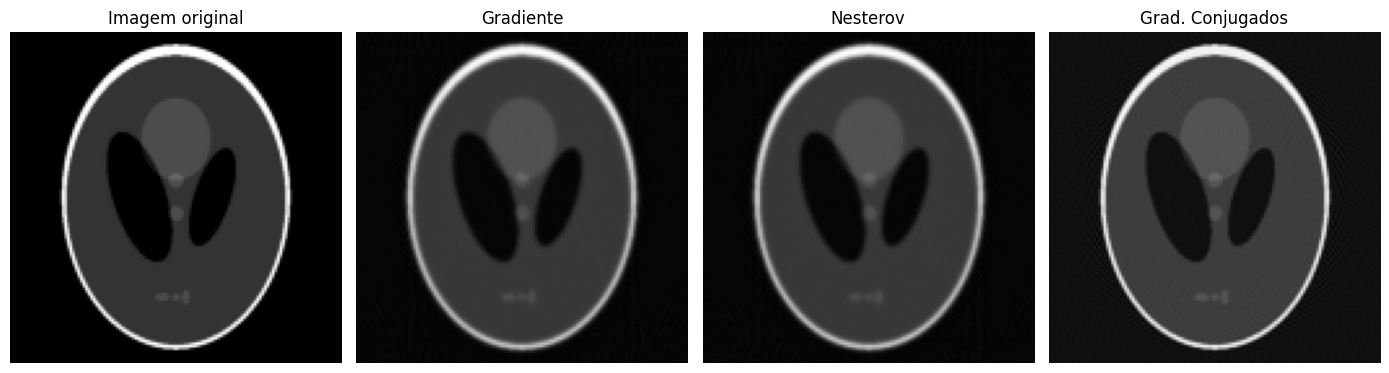

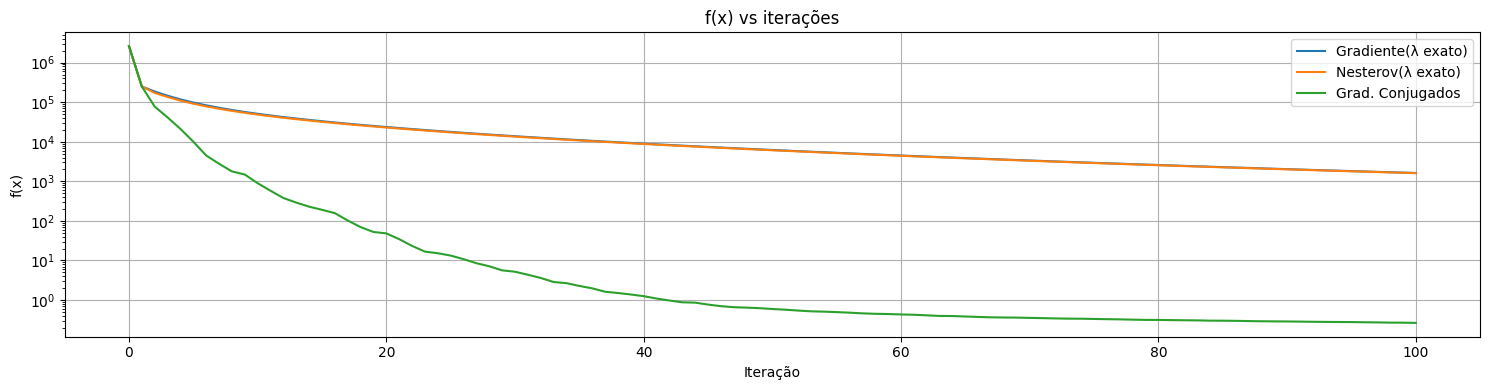

In [95]:
# ----------------------------
# Visualização
# ----------------------------
plt.figure(figsize=(14, 4))

# Imagem original
plt.subplot(1, 4, 1)
plt.title("Imagem original")
plt.imshow(image, cmap="gray")
plt.axis("off")

# Reconstrução - Gradiente
plt.subplot(1, 4, 2)
plt.title("Gradiente")
plt.imshow(reconstruction_dg, cmap="gray")
plt.axis("off")

# Reconstrução - Nesterov
plt.subplot(1, 4, 3)
plt.title("Nesterov")
plt.imshow(reconstruction_n, cmap="gray")
plt.axis("off")

# Reconstrução - Gradientes Conjugados
plt.subplot(1, 4, 4)
plt.title("Grad. Conjugados")
plt.imshow(reconstruction_cg, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

# ----------------------------
# Plot das funções f(x)
# ----------------------------
plt.figure(figsize=(15, 4))
plt.title("f(x) vs iterações")
plt.plot(f_values_dg, label="Gradiente(λ exato)")
plt.plot(f_values_n, label="Nesterov(λ exato)")
plt.plot(f_values_cg, label="Grad. Conjugados")
plt.yscale("log")
plt.xlabel("Iteração")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()